In [1]:
# =========================
# BLOCK 1 — PREPROCESSING
# =========================
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# ---- File paths ----
BASE = "/Users/adithyamadduri/Downloads/syn65414912"
ANML_PATH   = os.path.join(BASE, "OhNM2025_ROSMAP_plasma_Soma7k_protein_level_ANML_log10.csv")
SAMPLE_PATH = os.path.join(BASE, "OhNM2025_ROSMAP_plasma_Soma7k_sample_metadata.csv")

# ---- Load ----
df_levels = pd.read_csv(ANML_PATH)        # rows: projid_visit, cols: proteins
df_meta   = pd.read_csv(SAMPLE_PATH)      # contains projid_visit, projid, msex, age_at_visit, educ, apoe_genotype, Diagnosis

# ---- Sanity: keys present? ----
assert "projid_visit" in df_levels.columns, "projid_visit missing in protein matrix."
for col in ["projid_visit","projid","msex","age_at_visit","educ","apoe_genotype","Diagnosis"]:
    assert col in df_meta.columns, f"{col} missing in sample metadata."

# ---- Align on visit ----
# inner join so we only keep visits present in BOTH
df = pd.merge(df_meta, df_levels, on="projid_visit", how="inner", validate="one_to_one")
print("Aligned shape:", df.shape)

# ---- Labels (four groups) ----
df["Diagnosis"] = df["Diagnosis"].astype(str).str.strip()
valid_classes = {"MCI","NCI","AD","AD+"}
df = df[df["Diagnosis"].isin(valid_classes)].reset_index(drop=True)
print("Class counts:\n", df["Diagnosis"].value_counts())

# ---- Grouping key for leakage control ----
df["projid"] = df["projid"].astype(str)

# ---- Stratification label: Diagnosis × sex (0/1) ----
df["msex"] = df["msex"].astype(int)
df["strata"] = df["Diagnosis"] + "_" + df["msex"].astype(str)

# ---- APOE one-hot (Unknown for NaN) ----
def format_apoe(x):
    if pd.isna(x):
        return "Unknown"
    try:
        # e.g., 33.0 -> "33"
        return str(int(float(x)))
    except Exception:
        s = str(x).strip()
        return s if s else "Unknown"

df["apoe_str"] = df["apoe_genotype"].apply(format_apoe)

# scikit-learn compatibility across versions
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

apoe_ohe = ohe.fit_transform(df[["apoe_str"]])
apoe_cols = [c.replace("apoe_str_","APOE_") for c in ohe.get_feature_names_out()]
df_apoe  = pd.DataFrame(apoe_ohe, columns=apoe_cols, index=df.index)

# ---- Numeric covariates (unscaled) ----
for col in ["age_at_visit","educ"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ---- Protein feature columns ----
protein_cols = [c for c in df_levels.columns if c != "projid_visit"]

# ---- Final feature matrix X ----
X = pd.concat([df[["age_at_visit","educ"]], df_apoe, df[protein_cols]], axis=1)
y = df["Diagnosis"].astype(str).values
groups = df["projid"].values
strata = df["strata"].values

print("X shape:", X.shape)
print("APOE levels seen:", sorted(set(df["apoe_str"])))

Aligned shape: (973, 7301)
Class counts:
 Diagnosis
NCI    507
MCI    262
AD     167
AD+     17
Name: count, dtype: int64
X shape: (953, 7298)
APOE levels seen: ['22', '23', '24', '33', '34', '44', 'Unknown']


In [ ]:
import os
import pickle
import pandas as pd
from collections import Counter

# ---- Config ----
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)"
classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c): return c.replace("+", "plus").replace(" ", "_").replace("/", "-")


apoe_cols = [c for c in X.columns if c.startswith("APOE_")]
demo_cols_from_X = ["age_at_visit", "educ"] + apoe_cols   # sourced from X
demo_cols_from_df = ["msex"]   

# ---- Track all features with non-zero importance ----
# ---- Track features with non-zero importance PER CLASS ----
from collections import defaultdict

feature_counts_per_class = defaultdict(Counter)

for seed in seeds:
    for cls in classes:
        model_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl")
        if not os.path.exists(model_path):
            print(f"Missing: {model_path}")
            continue

        with open(model_path, "rb") as f:
            automl = pickle.load(f)

        importances = automl.model.estimator.feature_importances_
        features = automl.feature_names_in_
        nonzero_features = [feat for feat, imp in zip(features, importances) if imp > 0]
        feature_counts_per_class[cls].update(nonzero_features)

# ---- Filter to features appearing in at least 3 models ----
# ---- Get shared features per class (appearing in ≥3 models) ----
shared_features_per_class = {
    cls: [feat for feat, count in counter.items() if count >= 2]
    for cls, counter in feature_counts_per_class.items()
}

# ---- Output folder ----
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_Demo"
os.makedirs(out_dir, exist_ok=True)

for cls in classes:
    feats = shared_features_per_class.get(cls, [])
    print(f"[{cls}] Found {len(feats)} features with non-zero importance in ≥3 models.")

# =========================
# BLOCK 2 — RATIO TRAINING WITH RFE
# CHANGE: For each one-vs-all run, use ONLY the features that appear in ≥3 seeds for THAT CLASS.
# Assumes upstream variables exist: `X` (samples × features), `y` (labels),
# `protein_cols` (list of protein feature columns), `strata` (stratifier), `groups` (group ids).
# =========================
import numpy as np
from itertools import combinations
from flaml import AutoML
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier

# ---- Classes & seeds (kept for fidelity) ----
classes = ["MCI","NCI","AD","AD+"]
def safe_cls(c): return c.replace("+","plus").replace(" ","_").replace("/","-")
seeds = [1,2,3,4,5]

# ---- Custom group-aware stratified 70/30 split ----
def group_stratified_shuffle_split(df_index, strata_all, groups_all, test_size=0.30, random_state=0):
    rng = np.random.RandomState(random_state)
    data = pd.DataFrame({"idx": df_index, "strata": strata_all, "group": groups_all})
    grp_mode = data.groupby("group")["strata"].agg(lambda s: s.value_counts().idxmax())
    grp_mode = grp_mode.sample(frac=1.0, random_state=random_state)

    train_groups, test_groups = [], []
    for s_val, grp_ids in grp_mode.groupby(grp_mode.values):
        g_list = list(grp_ids.index)
        rng.shuffle(g_list)
        n_test = max(1, int(round(test_size * len(g_list))))
        test_groups.extend(g_list[:n_test])
        train_groups.extend(g_list[n_test:])

    train_mask = np.isin(groups_all, train_groups)
    test_mask = np.isin(groups_all, test_groups)
    return np.where(train_mask)[0], np.where(test_mask)[0]

# ---- FLAML training loop (per-class feature selection & ratios) ----
for cls in classes:
    # 1) Use only predictive features (≥3 seeds) for THIS class
    class_feats = shared_features_per_class.get(cls, [])
    protein_only_features = [f for f in class_feats if f in protein_cols]
    print(f"\n[{cls}] Using {len(protein_only_features)} protein features for ratio generation...")

    if len(protein_only_features) < 2:
        print(f"[{cls}] Not enough protein features to form ratios (need ≥2). Skipping.")
        continue

    # 2) Generate pairwise ratios from class-specific protein features
    ratio_cols = []
    ratio_data = []
    for f1, f2 in combinations(protein_only_features, 2):
        rname = f"{f1}_div_{f2}"
        ratio_cols.append(rname)
        ratio_data.append(X[f1] / X[f2])

    X_ratio_cls = pd.DataFrame(np.column_stack(ratio_data), columns=ratio_cols, index=X.index)
    print(f"[{cls}] X_ratio shape (before RFE): {X_ratio_cls.shape}")

    # 4) Seeded train/test + AutoML (one-vs-all for THIS class)
    for seed in seeds:
        tr_idx, te_idx = group_stratified_shuffle_split(
            df_index=np.arange(len(X_ratio_cls)),
            strata_all=strata,
            groups_all=groups,
            test_size=0.30,
            random_state=seed,
        )

        X_train = X_ratio_cls.iloc[tr_idx]
        X_test = X_ratio_cls.iloc[te_idx]
        y_train_full = y[tr_idx]
        y_test_full = y[te_idx]

        print(f"[{cls}] [Seed {seed}] Train n={len(tr_idx)} | Test n={len(te_idx)}")

        y_train = (y_train_full == cls).astype(int)
        y_test = (y_test_full == cls).astype(int)
        rfe_model = LGBMClassifier(n_estimators=100, random_state=0)
        n_select = min(100, X_train.shape[1])  # prevent crash if <100 features
        rfe = RFE(estimator=rfe_model, n_features_to_select=n_select, step=0.1)
        rfe.fit(X_train, y_train)

        selected_cols = list(X_train.columns[rfe.get_support()])
        X_train = X_train[selected_cols]
        X_test  = X_test[selected_cols]
        print(f"[{cls}] [Seed {seed}] Post-RFE: Train shape = {X_train.shape}, Test shape = {X_test.shape}")

        # >>> ADDED: append demo/APOE features AFTER RFE (not subject to RFE)
        X_train = pd.concat(
            [X_train,
            X.loc[X_train.index, demo_cols_from_X],
            df.loc[X_train.index, demo_cols_from_df]],
            axis=1
        )
        X_test = pd.concat(
            [X_test,
            X.loc[X_test.index, demo_cols_from_X],
            df.loc[X_test.index, demo_cols_from_df]],
            axis=1
        )

        # (optional but recommended) enforce identical column order
        X_test = X_test.reindex(columns=X_train.columns)

        automl = AutoML()
        settings = {
            "time_budget": 100,
            "metric": "roc_auc",
            "task": "classification",
            "eval_method": "cv",
            "estimator_list": ["lgbm"],
            "log_file_name": os.path.join(out_dir, f"flaml_seed{seed}_{safe_cls(cls)}.log"),
            "seed": seed,
        }

        automl.fit(X_train=X_train, y_train=y_train, **settings)
        automl.pickle(os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl"))

        y_score = automl.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score) if (y_test.sum() > 0 and y_test.sum() < len(y_test)) else float("nan")
        print(f"  [{cls}] AUC={auc:.3f}")

        out_csv = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        pd.DataFrame({
            "y_true": y_test.astype(int),
            "y_score": y_score.astype(float)
        }).to_csv(out_csv, index=False)

/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_23141/4171581705.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  automl = pickle.load(f)
/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_23141/4171581705.py:32: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usag

[MCI] Found 43 features with non-zero importance in ≥3 models.
[NCI] Found 351 features with non-zero importance in ≥3 models.
[AD] Found 156 features with non-zero importance in ≥3 models.
[AD+] Found 23 features with non-zero importance in ≥3 models.

[MCI] Using 43 protein features for ratio generation...
[MCI] X_ratio shape (before RFE): (953, 903)
[MCI] [Seed 1] Train n=670 | Test n=283
[LightGBM] [Info] Number of positive: 183, number of negative: 487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202272
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 903
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273134 -> initscore=-0.978778
[LightGBM] [Info] Start training from score -0.978778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

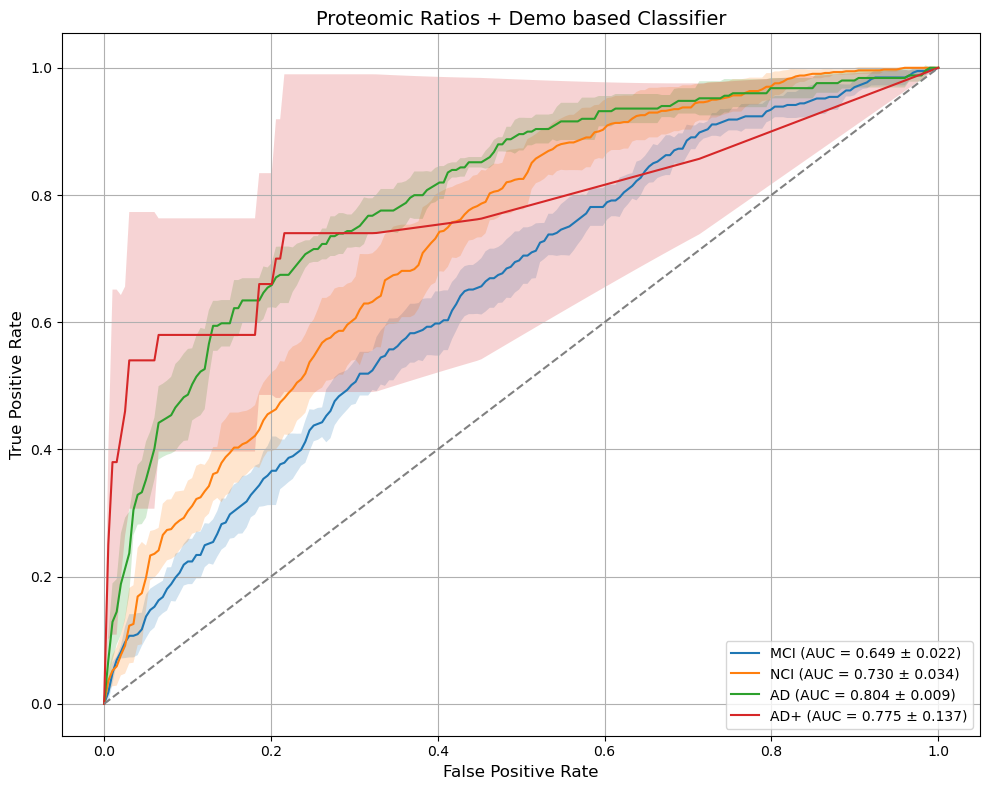

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- Config ---
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_Demo"
classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

# --- ROC Plotting ---
fpr_grid = np.linspace(0.0, 1.0, 200)
plt.figure(figsize=(10, 8))

for cls in classes:
    tprs = []
    aucs = []

    for seed in seeds:
        file_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        if not os.path.exists(file_path):
            print(f"Missing: {file_path}")
            continue

        df = pd.read_csv(file_path)
        fpr, tpr, _ = roc_curve(df["y_true"], df["y_score"])
        interp_tpr = np.interp(fpr_grid, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    if not tprs:
        continue

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(fpr_grid, mean_tpr, label=f"{cls} (AUC = {mean_auc:.3f} ± {std_auc:.3f})")
    plt.fill_between(fpr_grid, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)

# --- Finalize plot ---
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Proteomic Ratios + Demo based Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()  # or plt.savefig("roc_ratio_models.png", dpi=300)